In [181]:
import yfinance as yf
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
# Import the optimise sublibrary
import scipy.optimize as sco
# Import cubic splines interpolation module
import scipy.interpolate as sci

In [182]:
data = yf.download("AMZN AAPL GOOG ^GSPC", start="2017-01-01", end="2018-01-01")
def df(data,pm):
    df=data[pm]
    return df
data=df(data,"Close")
data

[*********************100%***********************]  4 of 4 completed


,AAPL,AMZN,GOOG,^GSPC
Date,,,,
2017-01-03,29.037500,37.683498,39.306999,2257.830078
2017-01-04,29.004999,37.859001,39.345001,2270.750000
2017-01-05,29.152500,39.022499,39.701000,2269.000000
2017-01-06,29.477501,39.799500,40.307499,2276.979980
2017-01-09,29.747499,39.846001,40.332500,2268.899902
...,...,...,...,...
2017-12-22,43.752499,58.417999,53.006001,2683.340088
2017-12-26,42.642502,58.838001,52.837002,2680.500000
2017-12-27,42.650002,59.112999,52.468498,2682.620117


In [183]:
# Normalize stock data based on initial price
def normalize(data):
  x = data.copy()
  for i in x.columns[0:]:
    x[i] = x[i]/x[i][0]
  return x
normalize(data)

# Function to plot interactive plot
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns[0:]:
    fig.add_scatter(x = df.index, y = df[i], name = i)
  fig.show()


In [184]:
interactive_plot(normalize(data), 'Normalized Prices')

In [185]:
def daily_return(df):
    df_daily_return = df.copy()
    df_daily_return=df_daily_return.pct_change()
    for i in df.columns[0:].tolist():
        df_daily_return[i][0] = 0
    return df_daily_return
stocks_daily_return = daily_return(data).iloc[:,:(len(data.columns))]
stocks_daily_return


,AAPL,AMZN,GOOG,^GSPC
Date,,,,
2017-01-03,0.000000,0.000000,0.000000,0.000000
2017-01-04,-0.001119,0.004657,0.000967,0.005722
2017-01-05,0.005085,0.030732,0.009048,-0.000771
2017-01-06,0.011148,0.019912,0.015277,0.003517
2017-01-09,0.009159,0.001168,0.000620,-0.003549
...,...,...,...,...
2017-12-22,0.000000,-0.005448,-0.003300,-0.000458
2017-12-26,-0.025370,0.007190,-0.003188,-0.001058
2017-12-27,0.000176,0.004674,-0.006974,0.000791


In [186]:
beta = {}
alpha = {}
import matplotlib.pyplot as plt

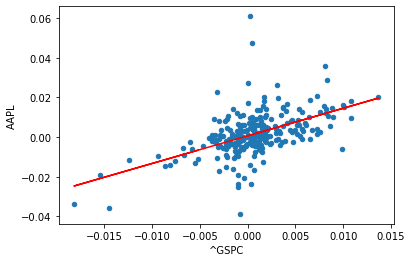

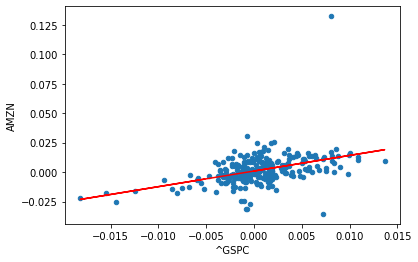

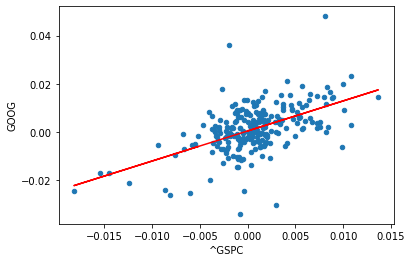

{'AAPL': 1.3929799878694449,
 'AMZN': 1.3238905280446664,
 'GOOG': 1.2499008778488752}

In [187]:
for i in stocks_daily_return.columns:
  if i != 'Date' and i != '^GSPC':
    stocks_daily_return.plot(kind = 'scatter', x = '^GSPC', y = i)
    b, a = np.polyfit(stocks_daily_return['^GSPC'], stocks_daily_return[i], 1)
    plt.plot(stocks_daily_return['^GSPC'], b * stocks_daily_return['^GSPC'] + a, '-', color = 'r')  
    beta[i] = b    
    alpha[i] = a  
    plt.show()
beta

In [188]:
keys = list(beta.keys())
beta

{'AAPL': 1.3929799878694449,
 'AMZN': 1.3238905280446664,
 'GOOG': 1.2499008778488752}

In [189]:
ER = {}

rf = 0 
rm = stocks_daily_return['^GSPC'].mean() * 252 
rm

0.17195316939324076

In [190]:
for i in keys:
  ER[i] = rf + (beta[i] * (rm-rf)) 
ER

{'AAPL': 0.23952732381550912,
 'AMZN': 0.22764717222697148,
 'GOOG': 0.21492441737350795}

In [191]:
stocks_daily_return.mean()*252

AAPL     0.393639
AMZN     0.462717
GOOG     0.299019
^GSPC    0.171953
dtype: float64

In [192]:
cov=stocks_daily_return.iloc[:,:3].cov()*252
var=stocks_daily_return.var()*252
cov


,AAPL,AMZN,GOOG
AAPL,0.031243,0.018940,0.013332
AMZN,0.018940,0.043947,0.021530
GOOG,0.013332,0.021530,0.023597


In [193]:
def generate_portfolios(df,n,n_s):
    mean_variance_pairs=[]
    weights_list=[]
    weights_list1=[]
    rs=[]
    sts=[]
    cov=df.iloc[:,:n_s].cov()*252
#-- Loop through and generate lots of random portfolios
    for i in range(n):
        asset_list=[]
        assets = np.random.choice(list(df.columns[:n_s]),n_s, replace=False)
        weights = np.random.rand(n_s)
        weights = weights/sum(weights)
        portfolio_E_Variance = 0
        portfolio_E_Return = 0
        for i in range(len(assets)):
            portfolio_E_Return += weights[i] * stocks_daily_return.iloc[:,i].mean()
            for j in range(len(assets)):
                portfolio_E_Variance +=weights[i]*weights[j] * cov.loc[assets[i], assets[j]]
        rs.append(portfolio_E_Return)
        sts.append(portfolio_E_Variance**0.5)
        for t in range(len(weights.tolist())): asset_list.append(str((assets.tolist())[t])+":"+str(round(weights.tolist()[t],2)))
        weights_list.append(" ".join(asset_list))
        weights_list1.append(weights)
        mean_variance_pairs.append([portfolio_E_Return,portfolio_E_Variance])
        mean_variance_pairs1={"return":portfolio_E_Return,"varince": portfolio_E_Variance,"assets":weights_list}
    mean_variance_pairs1 = pd.DataFrame(data=mean_variance_pairs1)
    mean_variance_pairs = np.array(mean_variance_pairs)

    return mean_variance_pairs, mean_variance_pairs1,weights_list1

In [194]:
stocks_daily_return=stocks_daily_return.iloc[:,:3]
stocks_daily_return

,AAPL,AMZN,GOOG
Date,,,
2017-01-03,0.000000,0.000000,0.000000
2017-01-04,-0.001119,0.004657,0.000967
2017-01-05,0.005085,0.030732,0.009048
2017-01-06,0.011148,0.019912,0.015277
2017-01-09,0.009159,0.001168,0.000620
...,...,...,...
2017-12-22,0.000000,-0.005448,-0.003300
2017-12-26,-0.025370,0.007190,-0.003188
2017-12-27,0.000176,0.004674,-0.006974


In [195]:
def generate_portfolios(df,n,n_s):
    rs=[]
    sts=[]
    weights_list=[]
    assets = np.random.choice(list(df.columns[:n_s]),n_s, replace=False)
    for i in range(n):
        asset_list=[]
        weights=np.random.random(len(df.columns[:(len(df.columns))]))
        weights /= np.sum(weights)
        rs.append(np.sum(df.iloc[:,:(len(df.columns))].mean()*weights)*252)
        sts.append(np.sqrt(np.dot(weights.T,np.dot(df.iloc[:,:(len(df.columns))].cov()*252,weights))))
        for t in range(len(weights.tolist())): asset_list.append(str((assets.tolist())[t])+":"+str(round(weights.tolist()[t],2)))
        weights_list.append(" ".join(asset_list))
    rs=np.array(rs)
    sts=np.array(sts)
    return rs,sts,weights_list,weights

In [196]:
a=generate_portfolios(stocks_daily_return,5000,3)
a[2]

['AAPL:0.31 GOOG:0.4 AMZN:0.29',
 'AAPL:0.73 GOOG:0.19 AMZN:0.08',
 'AAPL:0.3 GOOG:0.63 AMZN:0.07',
 'AAPL:0.06 GOOG:0.61 AMZN:0.34',
 'AAPL:0.66 GOOG:0.34 AMZN:0.0',
 'AAPL:0.15 GOOG:0.32 AMZN:0.53',
 'AAPL:0.39 GOOG:0.27 AMZN:0.34',
 'AAPL:0.17 GOOG:0.66 AMZN:0.17',
 'AAPL:0.39 GOOG:0.1 AMZN:0.51',
 'AAPL:0.56 GOOG:0.43 AMZN:0.02',
 'AAPL:0.41 GOOG:0.25 AMZN:0.34',
 'AAPL:0.29 GOOG:0.61 AMZN:0.11',
 'AAPL:0.24 GOOG:0.18 AMZN:0.58',
 'AAPL:0.39 GOOG:0.18 AMZN:0.43',
 'AAPL:0.33 GOOG:0.43 AMZN:0.24',
 'AAPL:0.53 GOOG:0.45 AMZN:0.02',
 'AAPL:0.03 GOOG:0.38 AMZN:0.59',
 'AAPL:0.06 GOOG:0.47 AMZN:0.48',
 'AAPL:0.54 GOOG:0.46 AMZN:0.01',
 'AAPL:0.53 GOOG:0.45 AMZN:0.02',
 'AAPL:0.51 GOOG:0.31 AMZN:0.18',
 'AAPL:0.43 GOOG:0.09 AMZN:0.48',
 'AAPL:0.03 GOOG:0.23 AMZN:0.73',
 'AAPL:0.23 GOOG:0.47 AMZN:0.3',
 'AAPL:0.5 GOOG:0.24 AMZN:0.26',
 'AAPL:0.44 GOOG:0.35 AMZN:0.21',
 'AAPL:0.2 GOOG:0.72 AMZN:0.08',
 'AAPL:0.13 GOOG:0.49 AMZN:0.37',
 'AAPL:0.4 GOOG:0.05 AMZN:0.55',
 'AAPL:0.12 GOOG:0.77 

In [197]:
a=generate_portfolios(stocks_daily_return,5000,3)
risk_free_rate=0
fig = go.Figure()
fig.add_trace(go.Scatter(x=a[1], 
                         y=a[0], 
                         text=a[2], 
                      #- Add color scale for sharpe ratio   
                      marker=dict(color=(a[0]-risk_free_rate)/(a[1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers'))
#- Add title/labels
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualised Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Sample of Random Portfolios',
                  coloraxis_colorbar=dict(title="Sharpe Ratio"))

In [198]:
stocks_daily_return

,AAPL,AMZN,GOOG
Date,,,
2017-01-03,0.000000,0.000000,0.000000
2017-01-04,-0.001119,0.004657,0.000967
2017-01-05,0.005085,0.030732,0.009048
2017-01-06,0.011148,0.019912,0.015277
2017-01-09,0.009159,0.001168,0.000620
...,...,...,...
2017-12-22,0.000000,-0.005448,-0.003300
2017-12-26,-0.025370,0.007190,-0.003188
2017-12-27,0.000176,0.004674,-0.006974


In [199]:
data

,AAPL,AMZN,GOOG,^GSPC
Date,,,,
2017-01-03,29.037500,37.683498,39.306999,2257.830078
2017-01-04,29.004999,37.859001,39.345001,2270.750000
2017-01-05,29.152500,39.022499,39.701000,2269.000000
2017-01-06,29.477501,39.799500,40.307499,2276.979980
2017-01-09,29.747499,39.846001,40.332500,2268.899902
...,...,...,...,...
2017-12-22,43.752499,58.417999,53.006001,2683.340088
2017-12-26,42.642502,58.838001,52.837002,2680.500000
2017-12-27,42.650002,59.112999,52.468498,2682.620117


In [200]:
def ptf_stats(weights):
    weights = np.array(weights)
    ptf_r = np.sum(stocks_daily_return.mean() * weights) * 252
    ptf_std = np.sqrt(np.dot(weights.T, np.dot(stocks_daily_return.cov() * 252, weights)))
    return {"return":ptf_r,"volatility": ptf_std, "sharpe":(ptf_r) / ptf_std}

# Minimise the negative value of the Sharpe ratio
def min_sharpe(weights):
    return -ptf_stats(weights)["sharpe"]
    # Write the constraint that the weights have to add up to 1

def minimize_volatility(weights):  
    # Note that we don't return the negative of volatility here because we 
    # want the absolute value of volatility to shrink, unlike sharpe.
    return ptf_stats(weights)["volatility"] 
def minimize_return(weights): 
    return -ptf_stats(weights)["return"]
    
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})

# Bound the weights (parameter inputs) to be within 0 and 1
bnds = tuple((0, 1) for x in range((len(stocks_daily_return.columns))))


# Starting parameter (weights) list as equal distribution
starting_ws = (len(stocks_daily_return.columns)) * [1. / (len(stocks_daily_return.columns)),]

# Call the minimisation function
opts = sco.minimize(min_sharpe, starting_ws, method='SLSQP', bounds=bnds, constraints=cons)
# Inspect the results


In [201]:
optimal_sharpe_weights=opts['x'].round(4)
list(zip(data.columns[:len(stocks_daily_return)],list(optimal_sharpe_weights)))

[('AAPL', 0.4745), ('AMZN', 0.3387), ('GOOG', 0.1867)]

In [202]:
weights_opt = opts['x']
weights_opt

array([0.47452906, 0.33874629, 0.18672465])

In [203]:
ptf_stats(weights_opt)

{'return': 0.3993706861441268,
 'volatility': 0.1551654770750164,
 'sharpe': 2.573837258600035}

In [204]:
optimal_stats = ptf_stats(optimal_sharpe_weights)
print(optimal_stats)

print('Optimal Portfolio Return: ', round(optimal_stats["return"]*100,4))
print('Optimal Portfolio Volatility: ', round(optimal_stats["volatility"]*100,4))
print('Optimal Portfolio Sharpe Ratio: ', round(optimal_stats["sharpe"],4))

{'return': 0.3993304569976965, 'volatility': 0.15514984718004765, 'sharpe': 2.5738372564059513}
Optimal Portfolio Return:  39.933
Optimal Portfolio Volatility:  15.515
Optimal Portfolio Sharpe Ratio:  2.5738


In [205]:
def min_var(weights):
    # Remember that variance is just standard deviation (volatility) squared
    return ptf_stats(weights)["volatility"]
# Call the optimisation fcuntion
opt_var = sco.minimize(min_var, starting_ws, method='SLSQP', bounds=bnds, constraints=cons)
# Inspect the results
opt_var


     fun: 0.14091612622866545
     jac: array([0.14090335, 0.14609294, 0.14092345])
 message: 'Optimization terminated successfully'
    nfev: 28
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([3.64202685e-01, 3.46944695e-18, 6.35797315e-01])

In [206]:
weights_opt_var = opt_var['x'].round(3)
weights_opt_var


array([0.364, 0.   , 0.636])

In [207]:

# Get the statistics for the absolute minimum variance portfolio
ptf_stats(weights_opt_var)

{'return': 0.33346026638243986,
 'volatility': 0.14091613440965026,
 'sharpe': 2.366373927154815}

In [208]:
# Set up two conditions, one for the target return level and one for the sum of the portfolio weights
cons2 = ({'type': 'eq', 'fun': lambda x: ptf_stats(x)["return"] - r},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# The boundary condition stays the same
bnds2 = tuple((0, 1) for x in weights_opt)
# Define a function that returns the volatility of a portfolio given a vector of weights
def min_port(weights):
    return ptf_stats(weights)["volatility"]

In [209]:
# Define a function to get the target returns and volatilities given a range of returns
def efficient_frontier(start_r, end_r, steps):
    target_rs = np.linspace(start_r, end_r, steps)
    target_stds = []
    for r in target_rs:
        cons2 = ({'type': 'eq', 'fun': lambda x: ptf_stats(x)["return"] - r},
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bnds2 = tuple((0, 1) for x in a[3])
        opt_var = sco.minimize(min_var, starting_ws, method='SLSQP', bounds=bnds2, constraints=cons2)
        target_stds.append(opt_var['fun'])
    target_stds = np.array(target_stds)
    return target_rs, target_stds

target_rs, target_stds= efficient_frontier(a[0].min(),a[0].max(),50)

In [212]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=a[1], 
                         y=a[0], 
                         text=a[2], 
                      #- Add color scale for sharpe ratio   
                      marker=dict(color=(a[0]-risk_free_rate)/(a[1]**0.5),  
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers'))
fig.add_trace(go.Scatter(
    x=target_stds, y=target_rs, marker=dict(symbol="x",color=((target_rs)/target_stds), 
                                  showscale=False, 
                                  size=7,colorscale="RdBu"
                                  ),mode="markers"
)

)
#- Add title/labels
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualised Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Sample of Random Portfolios',
                  coloraxis_colorbar=dict(title="Sharpe Ratio"))

: 